In [1]:
!pip install sklearn-crfsuite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.9 MB/s eta 0:00:00


In [ ]:
import os

# Check if files are in the current directory
os.listdir('/home')


['metadata', 'valid.txt', 'train.txt', 'test.txt']

In [2]:
# Example loading dataset from Colab's /content directory or Google Drive
train_file_path = '/home/train.txt'
test_file_path = '/home/test.txt'

# Load your train and test datasets
with open(train_file_path, 'r') as f:
    train_data = f.readlines()

with open(test_file_path, 'r') as f:
    test_data = f.readlines()

# Preview the data
print("Train data:", train_data[:5])  # Show first 5 lines
print("Test data:", test_data[:5])  # Show first 5 lines


Train data: ['-DOCSTART- -X- -X- O\n', '\n', 'EU NNP B-NP B-ORG\n', 'rejects VBZ B-VP O\n', 'German JJ B-NP B-MISC\n']
Test data: ['-DOCSTART- -X- -X- O\n', '\n', 'SOCCER NN B-NP O\n', '- : O O\n', 'JAPAN NNP B-NP B-LOC\n']


In [3]:
# Function to parse CoNLL formatted data into list of sentences
def parse_conll(data):
    sentences = []
    sentence = []
    for line in data:
        line = line.strip()
        if line:  # Non-empty line
            # Split the line by spaces, handling cases with more than two fields
            fields = line.split()
            # If there are at least two fields, extract token and label; otherwise, skip the line
            if len(fields) >= 2:
                token, label = fields[0], fields[-1]  # Use first and last field for token and label
                sentence.append((token, label))
        else:  # Empty line indicates end of sentence
            if sentence:
                sentences.append(sentence)
                sentence = []
    return sentences

# Parse the train and test data
train_sentences = parse_conll(train_data)
test_sentences = parse_conll(test_data)

# Preview parsed data
print("Train Sentences:", train_sentences[:1])  # Show first sentence
print("Test Sentences:", test_sentences[:1])  # Show first sentence

Train Sentences: [[('-DOCSTART-', 'O')]]
Test Sentences: [[('-DOCSTART-', 'O')]]


In [4]:
import os

# Check if files are in the current directory
os.listdir('/home')

# Example loading dataset from Colab's /content directory or Google Drive
train_file_path = '/home/train.txt'
test_file_path = '/home/test.txt'

# Load your train and test datasets
with open(train_file_path, 'r') as f:
    train_data = f.readlines()

with open(test_file_path, 'r') as f:
    test_data = f.readlines()

# Preview the data
print("Train data:", train_data[:5])  # Show first 5 lines
print("Test data:", test_data[:5])  # Show first 5 lines

# Function to parse CoNLL formatted data into list of sentences
def parse_conll(data):
    sentences = []
    sentence = []
    for line in data:
        line = line.strip()
        if line:  # Non-empty line
            # Split the line by spaces, handling cases with more than two fields
            fields = line.split()
            # If there are at least two fields, extract token and label; otherwise, skip the line
            if len(fields) >= 2:
                token, label = fields[0], fields[-1]  # Use first and last field for token and label
                sentence.append((token, label))
        else:  # Empty line indicates end of sentence
            if sentence:
                sentences.append(sentence)
                sentence = []
    return sentences

# Parse the train and test data
train_sentences = parse_conll(train_data)
test_sentences = parse_conll(test_data)

# Preview parsed data
print("Train Sentences:", train_sentences[:1])  # Show first sentence
print("Test Sentences:", test_sentences[:1])  # Show first sentence

# Define the prepare_data function to extract features
def prepare_data(sentences):
    """
    Extracts features from the sentences.

    Args:
        sentences: List of sentences, where each sentence is a list of (token, label) tuples.

    Returns:
        X: List of features for each sentence.
        y: List of labels for each sentence.
    """
    X = []
    y = []
    for sentence in sentences:
        X_sentence = []
        y_sentence = []
        for i, (token, label) in enumerate(sentence):
            # Basic feature extraction: word, is_capitalized, is_numeric
            features = {
                'word': token,
                'is_capitalized': token[0].isupper(),
                'is_numeric': token.isdigit(),
            }
            X_sentence.append(features)
            y_sentence.append(label)
        X.append(X_sentence)
        y.append(y_sentence)
    return X, y

# Extract features from your training and test sentences
X_train, y_train = prepare_data(train_sentences)
X_test, y_test = prepare_data(test_sentences)

# Preview feature extraction results
print("First training sentence features:", X_train[0])

Train data: ['-DOCSTART- -X- -X- O\n', '\n', 'EU NNP B-NP B-ORG\n', 'rejects VBZ B-VP O\n', 'German JJ B-NP B-MISC\n']
Test data: ['-DOCSTART- -X- -X- O\n', '\n', 'SOCCER NN B-NP O\n', '- : O O\n', 'JAPAN NNP B-NP B-LOC\n']
Train Sentences: [[('-DOCSTART-', 'O')]]
Test Sentences: [[('-DOCSTART-', 'O')]]
First training sentence features: [{'word': '-DOCSTART-', 'is_capitalized': False, 'is_numeric': False}]


In [5]:
from sklearn_crfsuite import CRF

# Initialize and train the CRF model
crf = CRF(
    algorithm='lbfgs',
    c1=0.1, c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

crf.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = crf.predict(X_test)

# Print the predicted labels for the first test sentence
print("Predicted Labels for first test sentence:", y_pred[0])


Predicted Labels for first test sentence: ['O']


In [6]:
# Function to extract entities from labels (just as a list of entities, for simplicity)
def get_entities(tokens, labels):
    entities = []
    current_entity = []

    for token, label in zip(tokens, labels):
        if label.startswith("B-"):  # Start of an entity
            if current_entity:
                entities.append(" ".join(current_entity))
            current_entity = [token]
        elif label.startswith("I-") and current_entity:
            current_entity.append(token)
        else:
            if current_entity:
                entities.append(" ".join(current_entity))
                current_entity = []

    if current_entity:  # If there’s an entity left at the end
        entities.append(" ".join(current_entity))

    return entities

# Compare entities
# The original code tries to iterate with pred_sentence as an individual predicted sentence.
# But it should iterate through the predicted labels separately for comparison.
for true_sentence, pred_labels in zip(test_sentences, y_pred):
    true_tokens, true_labels = zip(*true_sentence)
    true_entities = get_entities(true_tokens, true_labels)
    # Instead of trying to unpack pred_sentence, directly use true_tokens and pred_labels
    pred_entities = get_entities(true_tokens, pred_labels)

    print("True Entities:", true_entities)
    print("Predicted Entities:", pred_entities)
    print("Correctly Matched Entities:", set(true_entities) & set(pred_entities))
    print("Discrepancies:", set(true_entities) ^ set(pred_entities))
    print()

Streaming output truncated to the last 5000 lines.
True Entities: ['Super G']
Predicted Entities: ['Super']
Correctly Matched Entities: set()
Discrepancies: {'Super', 'Super G'}

True Entities: ['Pernilla Wiberg', 'Sweden']
Predicted Entities: ['Pernilla Wiberg', 'Sweden']
Correctly Matched Entities: {'Pernilla Wiberg', 'Sweden'}
Discrepancies: set()

True Entities: ['Hilde Gerg', 'Germany']
Predicted Entities: ['Hilde Gerg', 'Germany']
Correctly Matched Entities: {'Hilde Gerg', 'Germany'}
Discrepancies: set()

True Entities: ['Svetland Gladishiva', 'Russia']
Predicted Entities: ['Svetland Gladishiva', 'Russia']
Correctly Matched Entities: {'Svetland Gladishiva', 'Russia'}
Discrepancies: set()

True Entities: ['Warwara Zelenskaja', 'Russia']
Predicted Entities: ['Warwara Zelenskaja', 'Russia']
Correctly Matched Entities: {'Warwara Zelenskaja', 'Russia'}
Discrepancies: set()

True Entities: ['Florence Masnada', 'France']
Predicted Entities: ['Florence Masnada', 'France']
Correctly Match

In [ ]:
import re

# Sample lists of countries and capitals for demonstration
COUNTRIES = ["United States", "France", "Japan","Germany","Italy","Afghanistan", "Albania", "Algeria", "Andorra", "Angola", "Antigua and Barbuda", "Argentina", "Armenia", "Australia", "Austria", "Azerbaijan", "Bahamas", "Bahrain", "Bangladesh", "Barbados", "Belarus", "Belgium", "Belize", "Benin", "Bhutan", "Bolivia", "Bosnia and Herzegovina", "Botswana", "Brazil", "Brunei", "Bulgaria", "Burkina Faso", "Burundi", "Cabo Verde", "Cambodia", "Cameroon", "Canada", "Central African Republic", "Chad", "Chile", "China", "Colombia", "Comoros", "Congo (Congo-Brazzaville)", "Costa Rica", "Croatia", "Cuba", "Cyprus", "Czechia (Czech Republic)", "Denmark", "Djibouti", "Dominica", "Dominican Republic", "Ecuador", "Egypt", "El Salvador", "Equatorial Guinea", "Eritrea", "Estonia", "Eswatini (fmr. "Swaziland")", "Ethiopia", "Fiji", "Finland", "France", "Gabon", "Gambia", "Georgia", "Germany", "Ghana", "Greece", "Grenada", "Guatemala", "Guinea", "Guinea-Bissau", "Guyana", "Haiti", "Honduras", "Hungary", "Iceland", "India", "Indonesia", "Iran", "Iraq", "Ireland", "Israel", "Italy", "Jamaica", "Japan", "Jordan", "Kazakhstan", "Kenya", "Kiribati", "Korea (North)", "Korea (South)", "Kosovo", "Kuwait", "Kyrgyzstan", "Laos", "Latvia", "Lebanon", "Lesotho", "Liberia", "Libya", "Liechtenstein", "Lithuania", "Luxembourg", "Madagascar", "Malawi", "Malaysia", "Maldives", "Mali", "Malta", "Marshall Islands", "Mauritania", "Mauritius", "Mexico", "Micronesia (Federated States of)", "Moldova", "Monaco", "Mongolia", "Montenegro", "Morocco", "Mozambique", "Myanmar (formerly Burma)", "Namibia", "Nauru", "Nepal", "Netherlands", "New Zealand", "Nicaragua", "Niger", "Nigeria", "North Macedonia", "Norway", "Oman", "Pakistan", "Palau", "Palestine State", "Panama", "Papua New Guinea", "Paraguay", "Peru", "Philippines", "Poland", "Portugal", "Qatar", "Romania", "Russia", "Rwanda", "Saint Kitts and Nevis", "Saint Lucia", "Saint Vincent and the Grenadines", "Samoa", "San Marino", "Sao Tome and Principe", "Saudi Arabia", "Senegal", "Serbia", "Seychelles", "Sierra Leone", "Singapore", "Slovakia", "Slovenia", "Solomon Islands", "Somalia", "South Africa", "South Sudan", "Spain", "Sri Lanka", "Sudan", "Suriname", "Sweden", "Switzerland", "Syria", "Tajikistan", "Tanzania", "Thailand", "Timor-Leste", "Togo", "Tonga", "Trinidad and Tobago", "Tunisia", "Turkey", "Turkmenistan", "Tuvalu", "Uganda", "Ukraine", "United Arab Emirates", "United Kingdom", "United States of America", "Uruguay", "Uzbekistan", "Vanuatu", "Venezuela", "Vietnam", "Yemen", "Zambia", "Zimbabwe"]  # Extend with more country names
CAPITALS = ["Washington", "Paris", "Tokyo"]  # Extend with more capital city names

def is_country(entity):
    """Check if the entity is a country."""
    return entity in COUNTRIES

def is_capital(entity):
    """Check if the entity is a capital city."""
    return entity in CAPITALS

def is_vowel(entity):
    """Check if the entity starts with a vowel."""
    return entity[0].lower() in "aeiou"

def has_hyphen(entity):
    """Check if the entity contains a hyphen."""
    return '-' in entity

def categorize_entity(entity, true_label):
    """Categorize entity based on true label and additional conditions."""
    category = {
        "Entity": entity,
        "True Label": true_label,
        "Predicted as Country": False,  # Change 'false' to 'False'
        "Is Country": is_country(entity),
        "Is Capital": is_capital(entity),
        "Starts with Vowel": is_vowel(entity),
        "Contains Hyphen": has_hyphen(entity)
    }

    # Refine prediction based on label and properties
    if true_label == "place":
        category["Predicted as Country"] = category["Is Country"]

    return category

# Function to extract entities from labels and apply categorization
def get_entities(tokens, labels, true_labels=None):
    entities = []
    current_entity = []
    current_label = None

    for i, (token, label) in enumerate(zip(tokens, labels)):
        if label.startswith("B-"):  # Start of a new entity
            if current_entity:
                # Categorize the entity with conditions
                entities.append(categorize_entity(" ".join(current_entity), current_label))
            current_entity = [token]
            current_label = true_labels[i] if true_labels else label[2:]
        elif label.startswith("I-") and current_entity:
            current_entity.append(token)
        else:
            if current_entity:
                entities.append(categorize_entity(" ".join(current_entity), current_label))
                current_entity = []
                current_label = None

    # Add the last entity if it exists
    if current_entity:
        entities.append(categorize_entity(" ".join(current_entity), current_label))

    return entities

# Compare entities and display characteristics for refinement
for true_sentence, pred_labels in zip(test_sentences, y_pred):
    true_tokens, true_labels = zip(*true_sentence)
    true_entities = get_entities(true_tokens, true_labels, true_labels)  # True labels used for reference
    pred_entities = get_entities(true_tokens, pred_labels)  # Prediction labels without true reference

    print("True Entities with Attributes:", true_entities)
    print("Predicted Entities with Attributes:", pred_entities)
    matched_entities = set(e['Entity'] for e in true_entities) & set(e['Entity'] for e in pred_entities)
    discrepancies = set(e['Entity'] for e in true_entities) ^ set(e['Entity'] for e in pred_entities)
    print("Correctly Matched Entities:", matched_entities)
    print("Discrepancies:", discrepancies)
    print()

Streaming output truncated to the last 5000 lines.
True Entities with Attributes: [{'Entity': 'Super G', 'True Label': 'B-MISC', 'Predicted as Country': False, 'Is Country': False, 'Is Capital': False, 'Starts with Vowel': False, 'Contains Hyphen': False}]
Predicted Entities with Attributes: [{'Entity': 'Super', 'True Label': 'MISC', 'Predicted as Country': False, 'Is Country': False, 'Is Capital': False, 'Starts with Vowel': False, 'Contains Hyphen': False}]
Correctly Matched Entities: set()
Discrepancies: {'Super', 'Super G'}

True Entities with Attributes: [{'Entity': 'Pernilla Wiberg', 'True Label': 'B-PER', 'Predicted as Country': False, 'Is Country': False, 'Is Capital': False, 'Starts with Vowel': False, 'Contains Hyphen': False}, {'Entity': 'Sweden', 'True Label': 'B-LOC', 'Predicted as Country': False, 'Is Country': False, 'Is Capital': False, 'Starts with Vowel': False, 'Contains Hyphen': False}]
Predicted Entities with Attributes: [{'Entity': 'Pernilla Wiberg', 'True Label':

Overall Evaluation Metrics:
Accuracy: 0.93
Precision: 0.72
Recall: 0.76
F1 Score: 0.73

Classification Report:
              precision    recall  f1-score   support

       B-LOC      0.874     0.792     0.831      1668
      B-MISC      0.846     0.718     0.777       702
       B-ORG      0.710     0.678     0.693      1661
       B-PER      0.775     0.708     0.740      1617
       I-LOC      0.395     0.646     0.490       257
      I-MISC      0.518     0.662     0.581       216
       I-ORG      0.590     0.715     0.646       835
       I-PER      0.756     0.951     0.842      1156
           O      0.979     0.973     0.976     38554

    accuracy                          0.935     46666
   macro avg      0.716     0.760     0.731     46666
weighted avg      0.938     0.935     0.936     46666



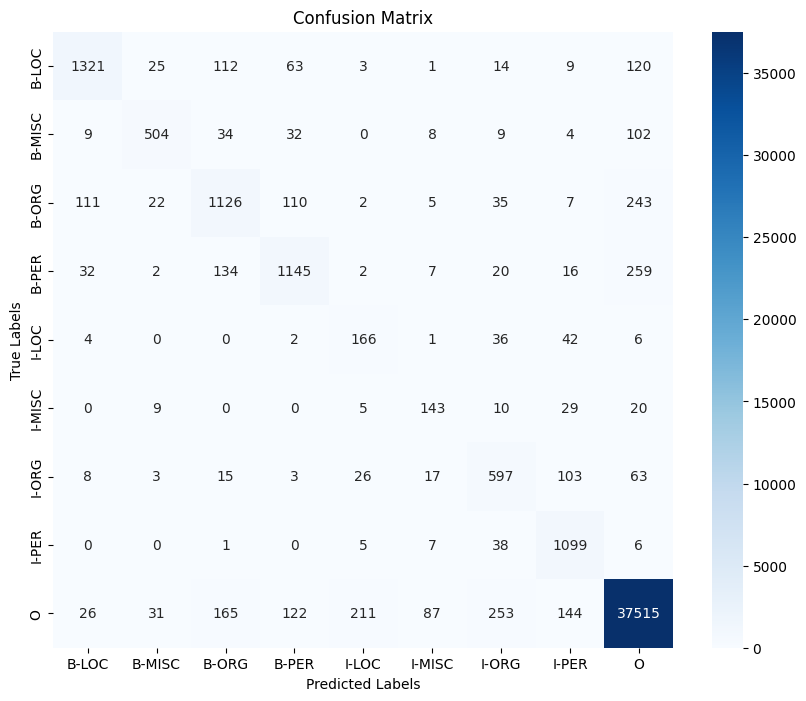

In [7]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn_crfsuite.metrics import flat_classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Flatten the lists of labels for computing metrics
y_test_flat = [label for sent in y_test for label in sent]
y_pred_flat = [label for sent in y_pred for label in sent]

# Calculate overall accuracy
accuracy = accuracy_score(y_test_flat, y_pred_flat)
precision = precision_score(y_test_flat, y_pred_flat, average='macro')
recall = recall_score(y_test_flat, y_pred_flat, average='macro')
f1 = f1_score(y_test_flat, y_pred_flat, average='macro')

print("Overall Evaluation Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}\n")

# Generate a classification report
print("Classification Report:")
print(flat_classification_report(y_test, y_pred, digits=3))

# Confusion Matrix
# Get unique labels for matrix and plot
labels = sorted(list(set(y_test_flat + y_pred_flat)))  # Ensure all labels are included
conf_matrix = confusion_matrix(y_test_flat, y_pred_flat, labels=labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
